# Exercises Week 9 in 02506: Developing a Neural Network for MNIST 

The dataset can be downloaded [as .gz files here](http://yann.lecun.com/exdb/mnist/).

<p align="center"> 
  <img src="../MNIST/raw/MNIST_images_train/image_train_00000.png" width="300" title="Very simple NN">
</p>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2
from skimage.io import imshow
import random
import torch

# import data handler
from datahandler import *

# for transformations
import torchvision.transforms as transforms

# Importing UNet
from UNet import *

### Defining on Load Transformations

In [2]:
trans = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomCrop(128,20),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(degrees = 45),
                                transforms.ToTensor()
                                ])

### Pre-processing of Data

torch.Size([10, 1, 128, 128])
torch.Size([10, 1, 128, 128])


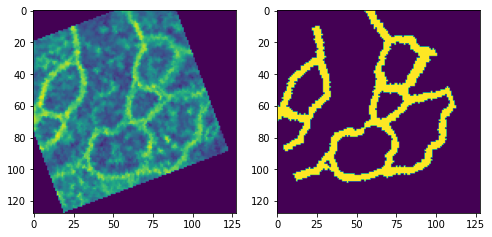

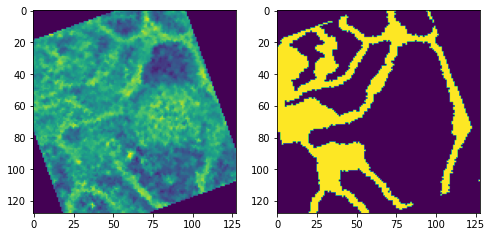

In [3]:
data_dir=r'./'
subset='train'
im_id=range(1,31)    
TrainData = DataHandler(
    data_dir, 
    im_id, 
    subset,
    is_ubuntu=True,
    img_trans=trans,
    lab_trans=trans)

a,b=TrainData.__getitem__(2)

# Define dataloader 
train_loader = DataLoader(dataset = TrainData, 
                                           batch_size = 10,
                                           shuffle = False,
                                           num_workers = 0)

pbar = enumerate(train_loader)
train_loss = []
for i, (images,target) in pbar:
    print(images.shape)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,10))
    ax1.imshow(images.numpy()[0][0])
    ax2.imshow(target.numpy()[0][0])
    break
for i, (images,target) in pbar:
    print(images.shape)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,10))
    ax1.imshow(images.numpy()[0][0])
    ax2.imshow(target.numpy()[0][0])
    break

### Defining Loss and Optimizer

In [4]:
#%% parameters
lr = 0.00008

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
else:
    device = torch.device('cpu')
    print('Using cpu')


model = UNet()

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


#%%
train_loader = DataLoader(dataset = TrainData, 
                                           batch_size = 10,
                                           shuffle = True,
                                           num_workers = 0)



Using cpu


### Defining Accuracy

In [5]:
def accuracy(y,t):
    y = np.round(y.detach().numpy())
    t = np.round(t.detach().numpy())
    B,M,N = np.shape(y)
    return  np.sum(y.flatten() == t.flatten())/(B*M*N)

### Training  the network

In [6]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

epochs = 25

N_train = len(train_loader)
N_test = 0
print(f"There are {N_train} training and {N_test} test batches")
for e in range(epochs):
    train_l = 0
    train_a = 0
    model.train()
    for i,tmp in enumerate(train_loader):
        x,t = tmp
        optimizer.zero_grad()
        y = model.forward(x)
        t = torch.round(t)
        #print(y[:,1,:,:].shape)
        #print(y[0,:,0,0])
        #print(t[:,0,:,:].shape)
        loss = loss_function(y[:,1,:,:],t[:,0,:,:])
        train_l += loss.item()
        loss.backward()
        optimizer.step()
        train_a += accuracy(y[:,1,:,:],t[:,0,:,:])
    train_loss.append(train_l/N_train)
    train_acc.append(train_a/N_train)
    model.eval()
    print(f"Finished epoch {e+1} of {epochs}. The loss is {train_l/N_train} and the accuracy is {train_a/N_train}")

There are 48 training and 0 test batches
Finished epoch 1 of 25
Finished epoch 2 of 25
Finished epoch 3 of 25
Finished epoch 4 of 25
Finished epoch 5 of 25
Finished epoch 6 of 25
Finished epoch 7 of 25
Finished epoch 8 of 25
Finished epoch 9 of 25
Finished epoch 10 of 25
Finished epoch 11 of 25
Finished epoch 12 of 25
Finished epoch 13 of 25
Finished epoch 14 of 25
Finished epoch 15 of 25
Finished epoch 16 of 25
Finished epoch 17 of 25
Finished epoch 18 of 25
Finished epoch 19 of 25
Finished epoch 20 of 25
Finished epoch 21 of 25
Finished epoch 22 of 25
Finished epoch 23 of 25
Finished epoch 24 of 25
Finished epoch 25 of 25


### Evaluating the Network

<bound method Figure.show of <Figure size 864x288 with 2 Axes>>

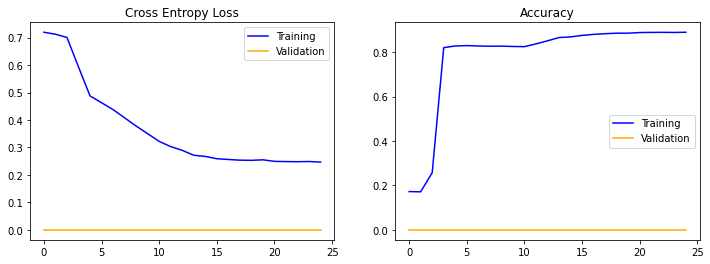

In [7]:
val_loss = 0*np.array(train_loss)
val_acc = 0*np.array(train_acc)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(range(0,epochs),train_loss,c = 'blue',label='Training')
ax1.plot(range(0,epochs),val_loss,c = 'orange',label='Validation')
ax1.legend()
ax1.set_title("Cross Entropy Loss")
ax2.plot(range(0,epochs),train_acc,c = 'blue',label='Training')
ax2.plot(range(0,epochs),val_acc,c = 'orange',label='Validation')
ax2.legend()
ax2.set_title("Accuracy")
fig.show

### Some examples of the Classification

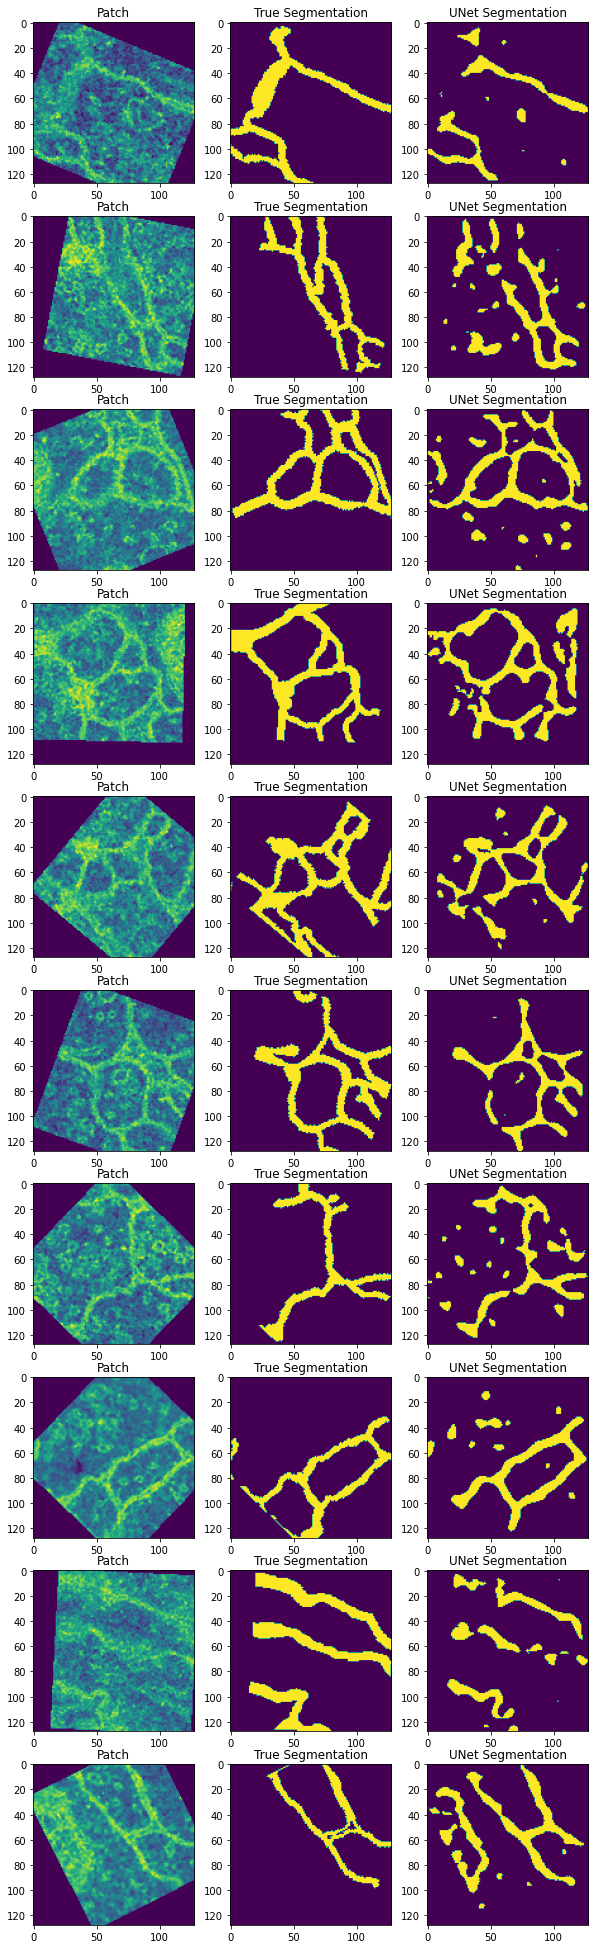

In [8]:
for i,tmp in enumerate(train_loader):
    x,t = tmp
    y = model.forward(x)
    t = torch.round(t)
    m = x.shape[0]
    n = 3

    fig, ax = plt.subplots(m,n,figsize=(10,3.5*m))

    for i in range(m):
        ax[i][0].imshow(x[i,0,:,:].detach().numpy())
        ax[i][0].set_title("Patch")
        ax[i][1].imshow(np.round(t[i,0,:,:].detach().numpy()))
        ax[i][1].set_title("True Segmentation")
        ax[i][2].imshow(np.round(y[i,1,:,:].detach().numpy()))
        ax[i][2].set_title("UNet Segmentation")

    break